The aim of this notebook is to assess the stability of the aggregation methods to shifts in ranges (i.e., panning).

In [1]:
%load_ext autoreload
%autoreload 2

In [4]:
import numpy as np
import plotly.graph_objects as go
import plotly.express as px
import pandas as pd

# prevent images from appearing in the notebook
from plotly_resampler.aggregation import LTTB, MinMaxAggregator, EveryNthPoint, AbstractSeriesAggregator
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

import sys

sys.path.append("..")
from agg_utils.aggregators import  M4Aggregator
from agg_utils.path_conf import  dataset_dir


In [3]:
# fmt: off
# Get that data that will be used for the analysis
btc_series = pd.read_parquet(dataset_dir / "btc_high.parquet").set_index('date')['high']
ball_speed_series = pd.read_parquet(dataset_dir / "ball_speed.parquet").set_index("ts")["v"]
power_series = pd.read_parquet( dataset_dir / "electrical_power.parquet").set_index("ts")["mf03"]
cinecg = pd.read_parquet(dataset_dir / "cinecg.parquet")['ECG']
# hf_sine = pd.read_parquet(dataset_dir / "hf_sine.parquet")['sine']
hf_noise = pd.read_parquet(dataset_dir / "hf_noise.parquet")['noise']
# repeat hf_noise to make it longer
hf_noise = pd.concat([hf_noise, hf_noise]).reset_index(drop=True)

# Data-space agreement - shifting range

In [5]:
from scipy.signal import find_peaks


def compute_residuals(
    series, n, n_out, aggregator: AbstractSeriesAggregator, offset_l: float, offset_r: float
) -> dict:
    """Compute the MAE, MSE, and MAE at the peaks of the residuals of the two aggregated
    series.

    Parameters
    ----------
    series : pd.Series
        The original series
    n : int
        The length of the series to aggregate
    n_out : int
        The number of points to select
    aggregator : AbstractSeriesAggregator
        The aggregator to use
    offset_l : float
        The offset of the left side of the series for the new aggregation
    offset_r : float
        The offset of the right side of the series for the new aggregation
    
    Returns
    -------
    dict
        A dictionary containing the MAE, MSE, and MAE at the peaks of the residuals
    """
    # Select the series
    offset_l = int(offset_l * n)
    offset_r = int(offset_r * n)
    if offset_l < 0:
        # If offset_l is negative, we right shift s1 with -offset_l
        start = -offset_l
        end = n + -offset_l
    else:
        # If the offset is positive, we can start s1 at 0
        start = 0
        end = n
    s1 = series.iloc[start:end]
    s2 = series.iloc[start + offset_l : end + offset_r]
    assert len(s1) == n
    assert len(s2) == n - offset_l + offset_r

    # Aggregate the series
    s1_agg = aggregator()._aggregate(s1, n_out)
    s2_agg = aggregator()._aggregate(s2, n_out)

    # Calculate where the series overlap
    overlap_l = max(start, start + offset_l)
    overlap_r = min(end, end + offset_r)
    # Reduce the series to the overlap
    s1_agg = s1_agg.loc[series.index[overlap_l]:series.index[overlap_r]]
    s2_agg = s2_agg.loc[series.index[overlap_l]:series.index[overlap_r]]

    # Interpolate the index of s2 to the index of s1
    s2_agg_interp = np.interp(
        s1_agg.index, s2_agg.index, s2_agg.values
    )
    
    # Calculate the range to scale with
    scale_range = s1_agg.max() - s1_agg.min()
    # volume_scale = np.sum(np.abs(np.diff(s1_agg.values)))
    # scale_range = min(s1_agg.max(), s2_agg.max()) - max(s1_agg.min(), s2_agg.min())
    # scale_range = np.sum(np.abs(np.diff(s1_agg.values)))
    # Calculate the residuals
    residuals = (s1_agg.values - s2_agg_interp) / scale_range
    # residuals_v = (s1_agg.values - s2_agg_interp) / volume_scale

    res = {} # dict to store the results

    # Calculate the MAE, MSE, and MAE at the peaks of the residuals
    res["MAE"] = np.abs(residuals).mean()
    # res["MAE_v"] = np.abs(residuals_v).mean()
    # res["MSE"] = (residuals ** 2).mean()
    # res["AE_max"] = np.abs(residuals).max()
    # res["SE_max"] = (residuals ** 2).max()

    # Find the peaks
    pos_peaks, _ = find_peaks(s1_agg.values, prominence=None)
    neg_peaks, _ = find_peaks(-s1_agg.values, prominence=None)
    peaks = np.concatenate([pos_peaks, neg_peaks])
    # sort peaks
    peaks = np.sort(peaks)
    # calculate the prominance
    res[f"MAE_peaks"] = np.abs(residuals[peaks]).mean()
    # res[f"MAE_peaks_v"] = np.abs(residuals_v[peaks]).mean()
    # res[f"MSE_peaks"] = (residuals[peaks] ** 2).mean()
    # res[f"AE_max_peaks"] = np.abs(residuals[peaks]).max()
    # res[f"SE_max_peaks"] = (residuals[peaks] ** 2).max()
    res[f"pct_peaks"] = len(peaks) / n_out

    return res

## Iteration 1

0.01816911250873515
0.02178649237472767
0.03208556149732621
0.03952569169960474
0.051383399209486175


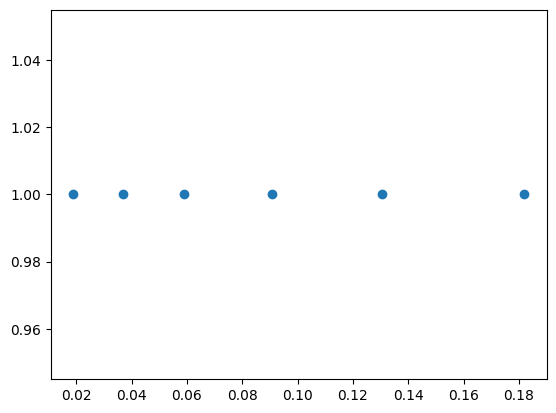

In [6]:
offsets = [1/53, 1/27, 1/17, 1/11, 3/23, 2/11]
plt.scatter(offsets, [1]*len(offsets))

# plot the deltas of the offsets
# deltas = []

for i in range(len(offsets) - 1):
    print(offsets[i+1] - offsets[i])
    # deltas.append(offsets[i+1] - offsets[i])

# plt.plot(deltas)

In [6]:
# fmt:off
df_list = []
for series_name, series in [
    ("ball", ball_speed_series),
    ("power", power_series),
    ("btc", btc_series),
    ("ecg", cinecg),
    ("hf_noise", hf_noise),
]:
    for n in tqdm([50_000, 200_000, 500_000, 1_000_000]):
        for n_out in tqdm([200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]): # TODO
            for offset in offsets:
                for aggregator_class in [ M4Aggregator, MinMaxAggregator, LTTB, EveryNthPoint ]:
                    ### Panning
                    # offset_l=offset, offset_r=offset => right panning
                    df_list.append(
                        {
                            "aggregator": aggregator_class.__name__,
                            "data": series_name,
                            "n": n,
                            "n_out": n_out,
                            "offset_l": offset,
                            "offset_r": offset,
                            **compute_residuals(
                                series, n, n_out, aggregator_class, offset_l=offset, offset_r=offset
                            )
                        }
                    )
                    # offset_l=-offset, offset_r=-offset => left panning
                    df_list.append(
                        {
                            "aggregator": aggregator_class.__name__,
                            "data": series_name,
                            "n": n,
                            "n_out": n_out,
                            "offset_l": -offset,
                            "offset_r": -offset,
                            **compute_residuals(
                                series, n, n_out, aggregator_class, offset_l=-offset, offset_r=-offset
                            )
                        }
                    )
                    ### Zooming out
                    # offset_l=0, offset_r=offset => right zoom out
                    df_list.append(
                        {
                            "aggregator": aggregator_class.__name__,
                            "data": series_name,
                            "n": n,
                            "n_out": n_out,
                            "offset_l": 0,
                            "offset_r": offset,
                            **compute_residuals(
                                series, n, n_out, aggregator_class, offset_l=0, offset_r=offset
                            )
                        }
                    )
                    # offset_l=-offset, offset_r=0 => left zoom out
                    df_list.append(
                        {
                            "aggregator": aggregator_class.__name__,
                            "data": series_name,
                            "n": n,
                            "n_out": n_out,
                            "offset_l": -offset,
                            "offset_r": 0,
                            **compute_residuals(
                                series, n, n_out, aggregator_class, offset_l=-offset, offset_r=0
                            )
                        }
                    )
                    # offset_l=-offset, offset_r=offset => left and right zoom
                    df_list.append(
                        {
                            "aggregator": aggregator_class.__name__,
                            "data": series_name,
                            "n": n,
                            "n_out": n_out,
                            "offset_l": -offset,
                            "offset_r": offset,
                            **compute_residuals(
                                series, n, n_out, aggregator_class, offset_l=-offset, offset_r=offset
                            )
                        }
                    )
                    ### Zooming in
                    # offset_l=offset, offset_r=0 => right zoom in
                    df_list.append(
                        {
                            "aggregator": aggregator_class.__name__,
                            "data": series_name,
                            "n": n,
                            "n_out": n_out,
                            "offset_l": offset,
                            "offset_r": 0,
                            **compute_residuals(
                                series, n, n_out, aggregator_class, offset_l=offset, offset_r=0
                            )
                        }
                    )
                    # offset_l=0, offset_r=-offset => left zoom in
                    df_list.append(
                        {
                            "aggregator": aggregator_class.__name__,
                            "data": series_name,
                            "n": n,
                            "n_out": n_out,
                            "offset_l": 0,
                            "offset_r": -offset,
                            **compute_residuals(
                                series, n, n_out, aggregator_class, offset_l=0, offset_r=-offset
                            )
                        }
                    )
                    # offset_l=offset, offset_r=-offset => left and right zoom in
                    df_list.append(
                        {
                            "aggregator": aggregator_class.__name__,
                            "data": series_name,
                            "n": n,
                            "n_out": n_out,
                            "offset_l": offset,
                            "offset_r": -offset,
                            **compute_residuals(
                                series, n, n_out, aggregator_class, offset_l=offset, offset_r=-offset
                            )
                        }
                    )



  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

In [8]:
df_metrics.data.value_counts()

ball        11520
power       11520
btc         11520
ecg         11520
hf_noise    11520
Name: data, dtype: int64

In [9]:
df_metrics.to_parquet("stability_metrics_.parquet")

## Working on the residuals

In [11]:
df_metrics = pd.read_parquet("stability_metrics_.parquet")

In [13]:
df_metrics["action"] = ""

# panning right
df_metrics.loc[(df_metrics.offset_l == df_metrics.offset_r) & (df_metrics.offset_l > 0), "action"] = "panning right"
# panning left
df_metrics.loc[(df_metrics.offset_l == df_metrics.offset_r) & (df_metrics.offset_l < 0), "action"] = "panning left"

# right zoom out
df_metrics.loc[(df_metrics.offset_l == 0) & (df_metrics.offset_r > 0), "action"] = "zoom-out right"
# left zoom out
df_metrics.loc[(df_metrics.offset_l < 0) & (df_metrics.offset_r == 0), "action"] = "zoom-out left"
# left and right zoom out
df_metrics.loc[(df_metrics.offset_l < 0) & (df_metrics.offset_r > 0), "action"] = "zoom-out left-and-right"

# right zoom in
df_metrics.loc[(df_metrics.offset_l > 0) & (df_metrics.offset_r == 0), "action"] = "zoom-in right"
# left zoom in
df_metrics.loc[(df_metrics.offset_l == 0) & (df_metrics.offset_r < 0), "action"] = "zoom-in left"
# left and right zoom in
df_metrics.loc[(df_metrics.offset_l > 0) & (df_metrics.offset_r < 0), "action"] = "zoom-in left-and-right"

# store the direction of the action
df_metrics["direction"] = df_metrics["action"].str.split(" ").str[-1]
# strip action to first word
df_metrics["action"] = df_metrics["action"].str.split(" ").str[0]
# store the action and direction in a single column
df_metrics["action_direction"] = df_metrics["action"] + " " + df_metrics["direction"]

display(df_metrics.action.value_counts())
display(df_metrics.describe())
display(df_metrics["n"].unique())

zoom-out    21600
zoom-in     21600
panning     14400
Name: action, dtype: int64

,n,n_out,offset_l,offset_r,MAE,MAE_peaks,pct_peaks
count,57600.000000,57600.000000,57600.000000,57600.000000,57600.000000,57600.000000,57600.000000
mean,437500.000000,1100.000000,0.000000,0.000000,0.064461,0.062057,0.705252
std,362933.929006,574.461251,0.089110,0.089110,0.080688,0.080945,0.130723
min,50000.000000,200.000000,-0.181818,-0.181818,0.000000,0.000000,0.235000
25%,162500.000000,600.000000,-0.042484,-0.042484,0.007824,0.006648,0.625000
50%,350000.000000,1100.000000,0.000000,0.000000,0.031286,0.029372,0.707500
75%,625000.000000,1600.000000,0.042484,0.042484,0.086970,0.076642,0.776667
max,1000000.000000,2000.000000,0.181818,0.181818,0.626231,0.628033,0.999000


zoom-out    3600
zoom-in     3600
panning     2400
Name: action, dtype: int64


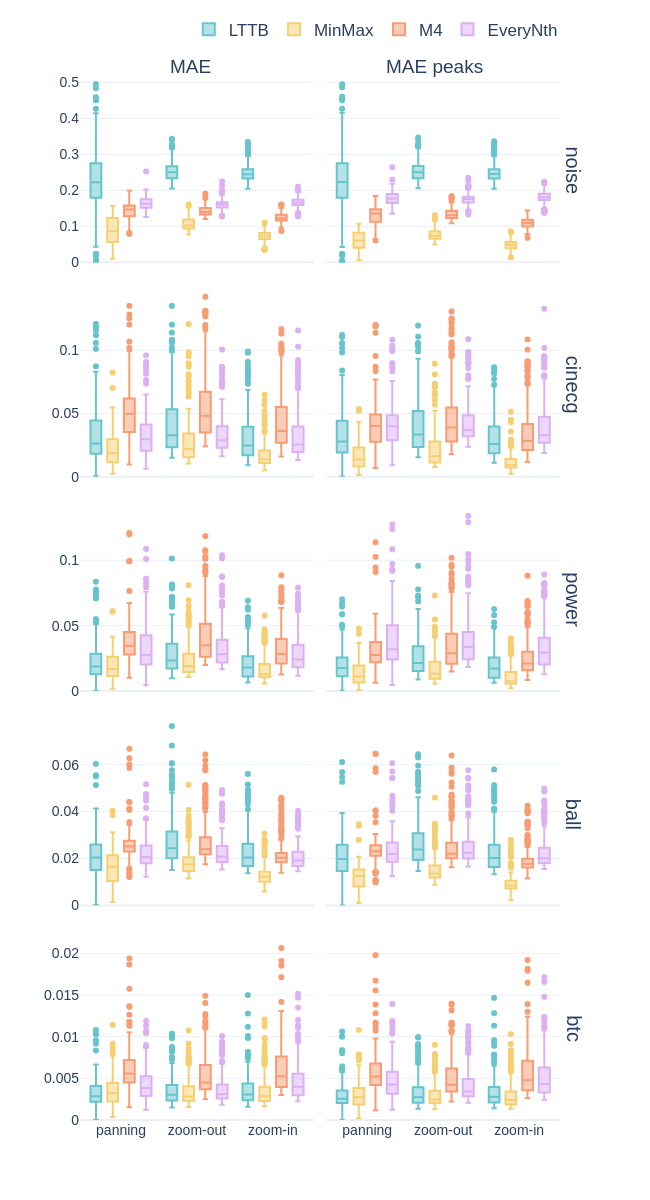

In [17]:
# paper visualization
df_vis = df_metrics.copy()

# aggregator mapping
aggregator_mapping = {
    "MinMaxAggregator": "MinMax",
    "M4Aggregator": "M4",
    "EveryNthPoint": "EveryNth",
}
df_vis["aggregator"] = df_vis["aggregator"].map(lambda x: aggregator_mapping.get(x, x))
interested_aggregators = ["LTTB", "MinMax", "M4", "EveryNth"]
interested_metrics = [ "MAE", "MAE_peaks", 
# "pct_peaks"
 ]

sub_df = df_vis[(df_vis.aggregator.isin(interested_aggregators))].copy()
sub_df = sub_df[sub_df.n == 200_000]
# rename ecg to cinecg and hf_noise to noise
sub_df.loc[sub_df.data == "ecg", "data"] = "cinecg"
sub_df.loc[sub_df.data == "hf_noise", "data"] = "noise"
print(sub_df["action"].value_counts())

fig = px.box(
    sub_df.melt(
        id_vars=[
            "aggregator",
            "data",
            "n",
            "n_out",
            "offset_l",
            "offset_r",
            "action",
            "direction",
            "action_direction",
        ],
        value_vars=interested_metrics,
    ),
    x="action",
    y="value",
    color="aggregator",
    facet_col="variable",
    facet_row="data",
    facet_col_spacing=0.025,
    facet_row_spacing=0.03,
    category_orders={
        "aggregator": interested_aggregators,
        "data": ["btc", "ball", "power", "cinecg", "noise"][::-1],
    },
    color_discrete_sequence=px.colors.qualitative.Pastel,
)


fig.update_layout(height=1080)  # , width=1300)
fig.update_yaxes(matches=None)  # showticklabels=True)

# place legend below plot
fig.update_layout(
    legend=dict(
        title_text="",
        orientation="h",
        yanchor="bottom",
        itemsizing="constant",
        y=1.03,
        xanchor="right",
        x=0.985,
        font_size=17,
    ),
    font_size=14,
    boxgap=0.12,
    boxgroupgap=0.35,
    # title="Visual stability of different aggregators - n=200k",
    # column widths
    template="plotly_white",
)

# update y axis titles
fig.update_yaxes(title_text="", showticklabels=True)
fig.update_xaxes(title_text="")
idxs_to_remove = []
for i in range(len(fig.layout.annotations)):
    if "data" in fig.layout.annotations[i].text:
        fig.layout.annotations[i].text = fig.layout.annotations[i].text.replace(
            "data=", ""
        )
        # increase the font size
        fig.layout.annotations[i].font.size = 20
    if "MAE" in fig.layout.annotations[i].text:
        idxs_to_remove.append(i)
    if "action" in fig.layout.annotations[i].text:
        idxs_to_remove.append(i)
# remove the unwanted annotations
fig.layout.annotations = tuple(
    [
        fig.layout.annotations[i]
        for i in range(len(fig.layout.annotations))
        if i not in idxs_to_remove
    ]
)
fig.add_annotation(
    xref="paper",
    yref="paper",
    x=0.18,
    y=1.0,
    xanchor="left",
    yanchor="bottom",
    text="MAE",
    showarrow=False,
    font_size=19,
)
fig.add_annotation(
    xref="paper",
    yref="paper",
    x=0.62,
    y=1.0,
    xanchor="left",
    yanchor="bottom",
    text="MAE peaks",
    showarrow=False,
    font_size=19,
)

for i, row_range in enumerate(
    [(0, 0.51), (0, 0.145), (0, 0.14), (0, 0.078), (0, 0.022)][::-1], 1
):
    fig.update_yaxes(range=row_range, row=i, col=1)
    fig.update_yaxes(range=row_range, row=i, col=2, showticklabels=False)

fig.show(renderer="png", width=650, height=1200)
# fig.write_html('visual_stability.html')

zoom-out    3600
zoom-in     3600
panning     2400
Name: action, dtype: int64


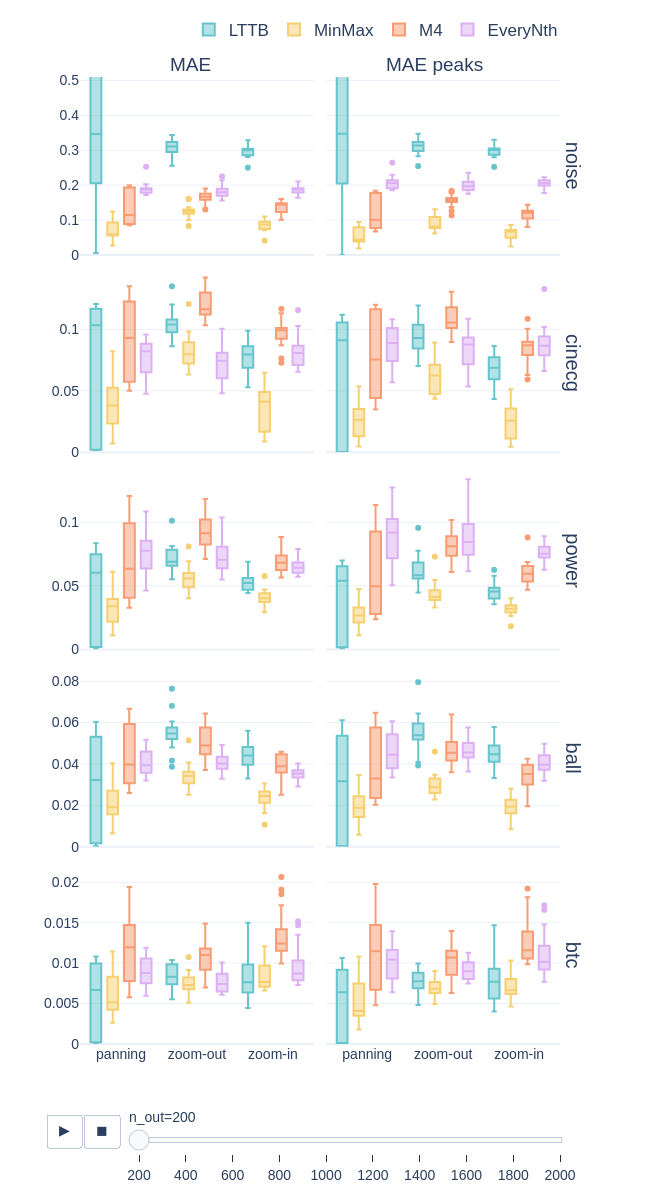

In [19]:
# paper visualization
df_vis = df_metrics.copy()

# aggregator mapping
aggregator_mapping = {
    "MinMaxAggregator": "MinMax",
    "M4Aggregator": "M4",
    "EveryNthPoint": "EveryNth",
}
df_vis["aggregator"] = df_vis["aggregator"].map(lambda x: aggregator_mapping.get(x, x))
interested_aggregators = ["LTTB", "MinMax", "M4", "EveryNth"]

interested_metrics = [
    "MAE",
    "MAE_peaks",
    # "pct_peaks",
]

sub_df = df_vis[(df_vis.aggregator.isin(interested_aggregators))].copy()
sub_df = sub_df[sub_df.n == 200_000]
# rename ecg to cinecg and hf_noise to noise
sub_df.loc[sub_df.data == "ecg", "data"] = "cinecg"
sub_df.loc[sub_df.data == "hf_noise", "data"] = "noise"
# sub_df = sub_df[sub_df.data != "noise"]
print(sub_df["action"].value_counts())

fig = px.box(
    sub_df.melt(
        id_vars=[
            "aggregator",
            "data",
            "n",
            "n_out",
            "offset_l",
            "offset_r",
            "action",
            "direction",
            "action_direction",
        ],
        value_vars=interested_metrics,
    ),
    x="action",
    y="value",
    color="aggregator",
    facet_col="variable",
    facet_row="data",
    animation_frame="n_out",
    # row spacing
    facet_col_spacing=0.025,
    facet_row_spacing=0.02,
    category_orders={
        "aggregator": interested_aggregators,
        "data": ["btc", "ball", "power", "cinecg", "noise"][::-1],
    },
    # use better colors
    color_discrete_sequence=px.colors.qualitative.Pastel,
)


fig.update_layout(height=1000)  # , width=1300)
# fig.update_annotations(font_size=20)
fig.update_yaxes(matches=None)  # showticklabels=True)
# place legend below plot
fig.update_layout(
    legend=dict(
        title_text="",
        orientation="h",
        yanchor="bottom",
        itemsizing="constant",
        y=1.03,
        xanchor="right",
        x=0.985,
        font_size=17,
    ),
    font_size=14,
    boxgap=0.12,
    boxgroupgap=0.35,
    # title="Visual stability of different aggregators - n=200k",
    # column widths
    template="plotly_white",
)

# update y axis titles
fig.update_yaxes(title_text="", showticklabels=True)
fig.update_xaxes(title_text="")
idxs_to_remove = []
for i in range(len(fig.layout.annotations)):
    if "data" in fig.layout.annotations[i].text:
        fig.layout.annotations[i].text = fig.layout.annotations[i].text.replace(
            "data=", ""
        )
        # increase the font size
        fig.layout.annotations[i].font.size = 20
    if "MAE" in fig.layout.annotations[i].text:
        idxs_to_remove.append(i)
    if "action" in fig.layout.annotations[i].text:
        idxs_to_remove.append(i)
# remove the unwanted annotations
fig.layout.annotations = tuple(
    [
        fig.layout.annotations[i]
        for i in range(len(fig.layout.annotations))
        if i not in idxs_to_remove
    ]
)
fig.add_annotation(
    xref="paper",
    yref="paper",
    x=0.18,
    y=1.0,
    xanchor="left",
    yanchor="bottom",
    text="MAE",
    showarrow=False,
    font_size=19,
)
fig.add_annotation(
    xref="paper",
    yref="paper",
    x=0.62,
    y=1.0,
    xanchor="left",
    yanchor="bottom",
    text="MAE peaks",
    showarrow=False,
    font_size=19,
)

for i, row_range in enumerate(
    [(0, 0.51), (0, 0.145), (0, 0.14), (0, 0.086), (0, 0.022)][::-1], 1
):
    fig.update_yaxes(range=row_range, row=i, col=1)
    fig.update_yaxes(range=row_range, row=i, col=2, showticklabels=False)

fig.show(renderer="png", width=650, height=1200)
# fig.write_html('visual_stability_frame.html')

In [21]:
# html output of the above plot
fig.update_layout(width=650).show()